In [31]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,3)
%matplotlib inline

## Load Data

In [2]:
weather_air = pd.read_csv('weather_airport.csv',parse_dates=[0])
weather= pd.read_csv('weather.csv',parse_dates=[0])
power = pd.read_csv('power.csv',parse_dates=[0])

### Power

In [3]:
# Cleaning up column names and adding new columns
power.rename(index = {'Unnamed: 0':'0'}, columns = {'Unnamed: 0':'Timestamp'}, inplace=True)
power['Date'] = power.Timestamp.dt.date
power['Hour'] = power.Timestamp.dt.hour
power['Quarter_Hour'] = power.Timestamp.dt.minute//15

In [159]:
power.head(2)

,Timestamp,8576,8577,8578,8579,8580,8595,8596,8597,8604,...,8565,8566,8567,8568,8570,8572,8575,Date,Hour,Quarter_Hour
0,2016-07-27 03:01:00,2600.0,2809.999756,1691.041382,1452.576050,1304.252808,2240.0,2809.999756,2619.999756,339.0,...,5740.0,7770.0,6150.0,12456.911133,12848.047852,12748.053711,2650.0,2016-07-27,3,0
1,2016-07-27 03:02:00,2600.0,2809.999756,74.076866,-109.096542,339.914764,2240.0,2809.999756,2619.999756,339.0,...,5740.0,7770.0,6150.0,2600.000000,2630.000000,2830.000000,2650.0,2016-07-27,3,0


#### Comments
1. The power data was logged over a contiguous period from starting late July 2016 thru mid January 2017. The January and July data being incomplete, should be treated with caution in terms of interpreating the peaks.

### Weather

In [100]:
weather.rename(index = None, columns = {'Unnamed: 0':'Timestamp'}, inplace=True)
weather_air.rename(index = None, columns = {'Unnamed: 0':'Timestamp'}, inplace=True)
weather['Date'] = pd.to_datetime(weather.Timestamp.dt.date)
weather['Hour'] = weather.Timestamp.dt.hour

### Aggregate power data into 15-minute wide bins

In [145]:
agg_pw = power.groupby(['Date','Hour','Quarter_Hour'], as_index=None).mean()#Average load over a 15 min. period
agg_pw['Date'] = pd.to_datetime(agg_pw.Date)

### Total power demand for the entire building

In [146]:
agg_pw['Total_demand'] = agg_pw.iloc[:,3:].sum(axis = 1)

### List the circuit that is consuming maximum power

In [147]:
agg_pw['Max_load'] = agg_pw.iloc[:,3:-1].idxmax(axis = 1)
agg_pw.head()

,Date,Hour,Quarter_Hour,8576,8577,8578,8579,8580,8595,8596,...,7152,8565,8566,8567,8568,8570,8572,8575,Total_demand,Max_load
0,2016-07-27,3,0,2600.0,2809.999756,409.491988,141.545637,526.747070,2240.000000,2809.999756,...,5788.567139,5740.000000,7770.000000,6150.00000,8581.224452,8811.420707,8813.773002,2650.0,317648.694979,8761
1,2016-07-27,3,1,2600.0,2809.999756,1799.999878,1568.961646,1410.000000,2254.036589,2810.214388,...,5433.397868,5740.000000,7770.000000,6150.00000,27200.000000,27999.998047,27400.000000,2650.0,374214.211000,8570
2,2016-07-27,3,2,2600.0,2809.999756,1467.926907,854.606490,953.702138,2260.000000,2809.999756,...,5792.155794,5740.000000,7847.103874,6169.19974,15954.282520,16410.880208,16165.585254,2650.0,343437.692770,8761
3,2016-07-27,3,3,2600.0,2809.999756,1300.000000,1039.416317,1084.937492,2260.000000,2809.999756,...,6205.359017,5723.063184,7970.000000,6200.00000,22099.441195,22662.315527,22300.148226,2650.0,365091.816762,8570
4,2016-07-27,4,0,2600.0,2809.999756,787.146466,832.902541,934.567562,2268.030192,2809.999756,...,5396.170996,5720.000000,7970.000000,6200.00000,15708.447428,16103.008724,15923.215234,2650.0,334682.241874,8761


## Peak analysis

### Locate the monthly power peaks

In [273]:
peak_power_rows = agg_pw.groupby(pd.to_datetime(agg_pw.Date).dt.month).Total_demand.idxmax(axis = 0)
peaks = agg_pw.iloc[peak_power_rows,:]
peaks.loc[:,'Month'] = peaks.Date.dt.month
peaks = peaks[['Month','Date', 'Hour', 'Max_load' , 'Total_demand']]
peaks.loc[:,'Day_of_week'] = peaks.Date.dt.dayofweek
peaks.rename(columns = {'Total_demand':'Peak_demand'}, inplace = True)
peaks

,Month,Date,Hour,Max_load,Peak_demand,Day_of_week
16081,1,2017-01-10,15,8570,381065.361268,1
464,7,2016-07-31,23,8570,400839.065427,6
2680,8,2016-08-24,1,8570,412618.359568,2
5931,9,2016-09-26,21,8570,595885.873846,0
8246,10,2016-10-21,0,8570,584327.757058,4
9301,11,2016-11-01,0,7146,503854.196472,1
13629,12,2016-12-16,2,8570,391937.694351,4


In [332]:
peaks.index[2]

2680

### Breakdown of monthly peaks by circuit (top 10)

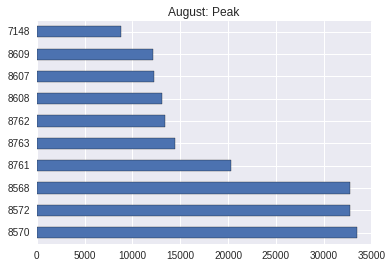

In [361]:
agg_pw.iloc[peaks.index[2],3:-2].sort_values(ascending = False)[:10].plot('barh', title = 'August: Peak')

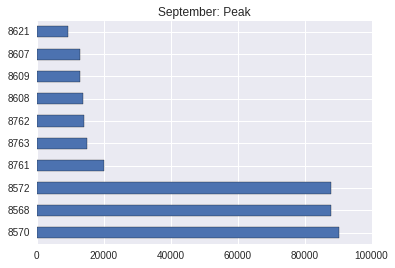

In [362]:
agg_pw.iloc[peaks.index[3],3:-2].sort_values(ascending = False)[:10].plot('barh', title = 'September: Peak')

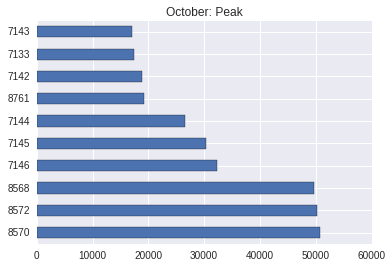

In [363]:
agg_pw.iloc[peaks.index[4],3:-2].sort_values(ascending = False)[:10].plot('barh',  title = 'October: Peak')

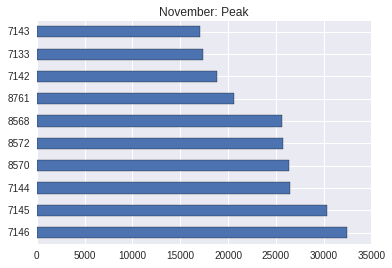

In [364]:
agg_pw.iloc[peaks.index[5],3:-2].sort_values(ascending = False)[:10].plot('barh', title = 'November: Peak')

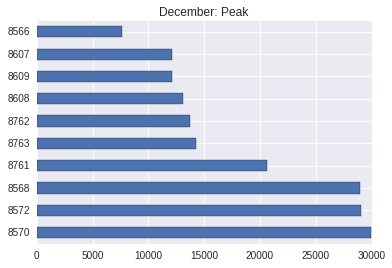

In [365]:
agg_pw.iloc[peaks.index[6],3:-2].sort_values(ascending = False)[:10].plot('barh',title = 'December: Peak')

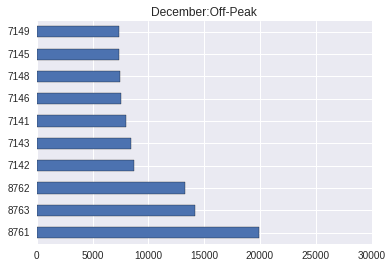

In [369]:
agg_pw.iloc[14000,3:-2].sort_values(ascending = False)[:10].plot('barh',title = 'December:Off-Peak', xlim= [0,30000])

### What's causing the peaks?
From the above charts, we observe that the following circuits contribute predominantly to the peaks: 
**8568**, **8570**, **8572** Let's visualize their individual contributions.

#### Average load (hourly) from  each circuit

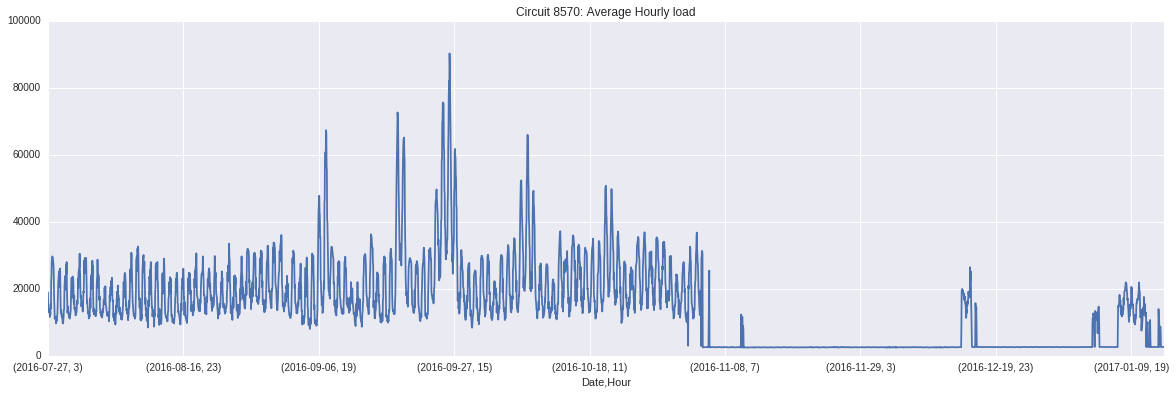

In [360]:
pow_weather = agg_pw.merge(weather, how = 'left', on = ['Date','Hour'])
pow_weather.groupby([pow_weather.Date.dt.date,'Hour'])['8570'].mean().plot(figsize = (20,6),title = 'Circuit 8570: Average Hourly load')

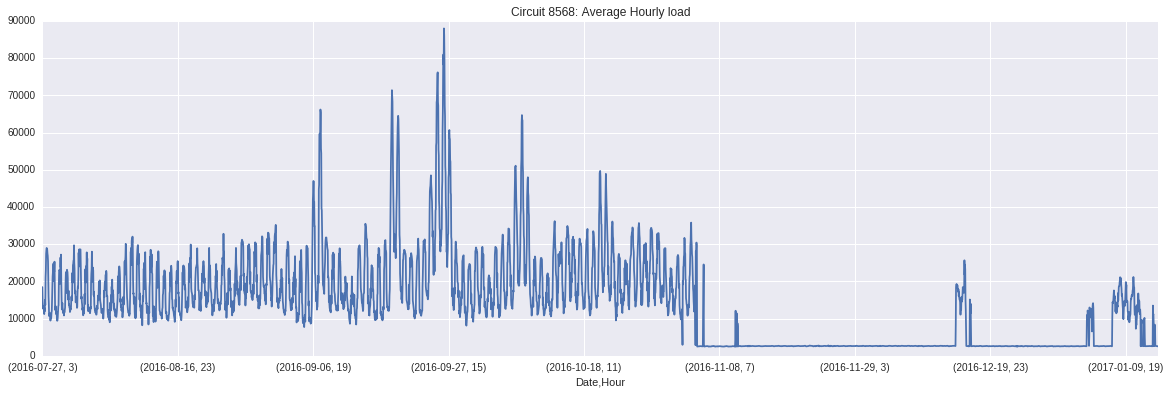

In [359]:
pow_weather.groupby([pow_weather.Date.dt.date,'Hour'])['8568'].mean().plot(figsize = (20,6),title = 'Circuit 8568: Average Hourly load')

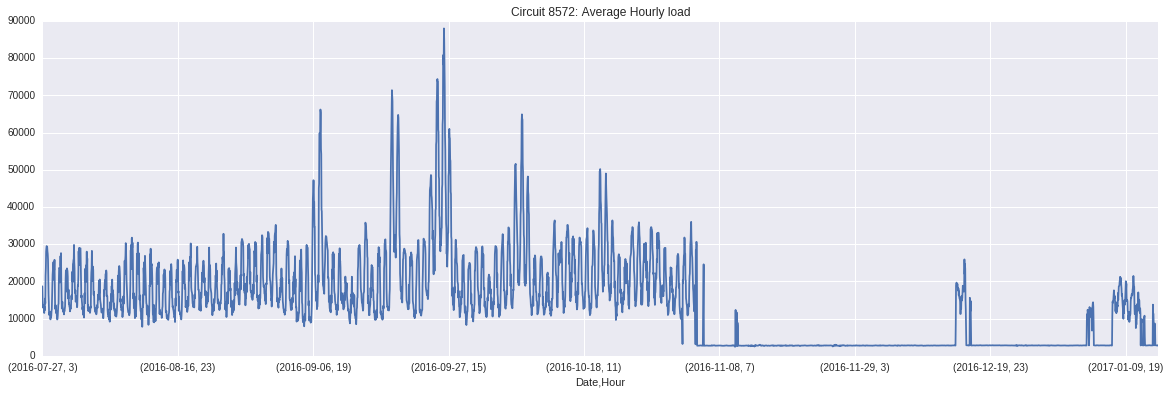

In [372]:
pow_weather.groupby([pow_weather.Date.dt.date,'Hour'])['8572'].mean().plot(figsize = (20,6), title = 'Circuit 8572: Average Hourly load')

#### Conclusion
The peaks are caused by the three circuits (8568, 8570, 8572). The start flatness of each of those time series in the right half of the curve(aside from the occasional spike) corresponds to the onset of cooler temperatures starting November. The temperature plot below confirms this hypothesis, as seen by a downward trend in temperature coinciding with the flattening of the power. This indicates that the circuits in question are almost certainly part of the **building air-conditioning system**. It is noteworthy that no 'winter spikes' are observed since large-scale heating systems usually run on gas. 

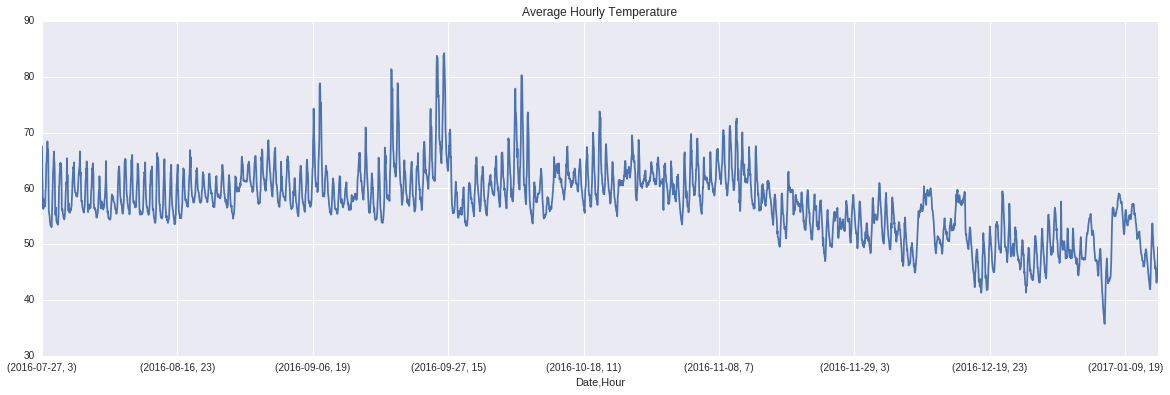

In [370]:
pow_weather.groupby([pow_weather.Date.dt.date,'Hour']).temperature.mean().plot(figsize = (20,6),title = 'Average Hourly Temperature')

### Peak Alerting Mechanism
The basic idea is to monitor the power demand continously and issue an alert when that quantity exceeds a certain threshold value. The model will be built in the following two steps:

#### I) Choosing a threshold

The appropriate choice for the threshold will depend on the intended level of tradeoff between false positives vs true negatives. In addition, the weather data may be used to make the model more reliable.

Assumptions:

1) The peaks are driven primarily by the presumed air-conditioning circuits (8568, 8570, 8572).
Therefore, this model is most appropriate to use during the warmer months. Due to the unavailability of year-round data, we will not attempt to generalize the model to the winter months, where the peaks would invariably be driven by a different dynamic. Ideally, we would want to build multiple separate models, each covering a specific time period (say, a  month).

2) We shall use the total power demand from the 3 'AC' circuits as the target variable defining a possible peak.

In [416]:
summer = pow_weather[pow_weather.Date <= '10/31/2016'] # Subset to the summer data only
summer.loc[:,'AC_circuits'] = summer['8568']+summer['8570']+summer['8572'] # Total 'AC' load

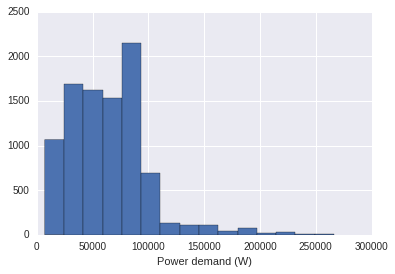

In [421]:
ax = summer.AC_circuits.hist(bins = 15)
ax.set_xlabel("Power demand (W)")

**Distribution of AC loads**

Based on the above histogram, we choose a threshold value of **100000 W** (left end of the 'tail') as an appropriate criterion for issuing a peak alert.

#### II) Forecasting  a peak using weather data
 
We expect the AC load to correlate strongly with the outside temperature and humidity. Let's verify this via a scatterplot.

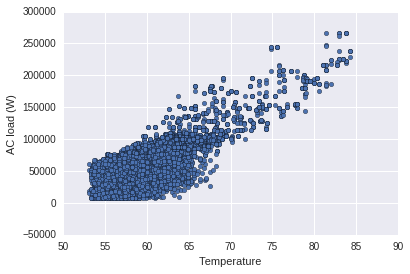

In [422]:
ax1 = summer.plot('temperature','AC_circuits', kind = 'scatter', legend = True)
ax1.set_xlabel('Temperature')
ax1.set_ylabel('AC load (W)')

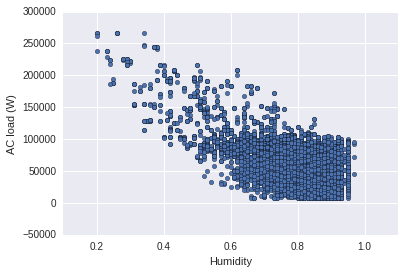

In [466]:
ax1 = summer.plot('humidity','AC_circuits', kind = 'scatter', legend = True)
ax1.set_xlabel('Humidity')
ax1.set_ylabel('AC load (W)')

The scatterplots shows a reasonably strong correlations. We can use the current temperature to forecast whether a peak might occur within the next 15 to 30 mins, assuming that the temperature and humidity will not vary significantly during that period. Alternately, a reliable temperature forecast could be used instead.

In [426]:
summer.loc[:,'Month'] = summer.Date.dt.month

In [506]:
summer.loc[:,'DayOfWeek'] = summer.Date.dt.dayofweek

### Model description
We use a **cross-validated logistic regression** classifier to predict a possible impending peak.

**Target**: The dependent variable (response) is a binary label denoting whether the alert should be made or not.

0: No peak alert

1: Peak alert

**Predictors**: We use the following features: **temperature**, **humidity**, and **month**

In [674]:
from sklearn.linear_model import LogisticRegressionCV as lrcv, RidgeCV
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
threshold = 100000
summer = summer.reindex(np.random.permutation(summer.index))#Randomize the data rows so that chronological order is broken
#response = np.array(summer.AC_circuits > threshold).astype(int)
response = np.array(summer.AC_circuits)
features = np.array(summer[['temperature','humidity','Month','DayOfWeek']])
X_train, X_test, y_train, y_test = train_test_split(features, response, test_size=0.33, random_state =42)

In [669]:
model = RidgeCV(cv = 10)

In [655]:
model = rf(n_estimators= 200, min_samples_split= 300, max_depth= 5, class_weight= {0:1, 1:10})

In [586]:
model = lrcv(class_weight= 'balanced', scoring= 'recall')

In [675]:
model.fit(X_train, y_train)

RidgeCV(alphas=(0.1, 1.0, 10.0), cv=10, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)

### Result: 
We use two different subsets of the data for training and testing. Using the area under the ROC curve as the model performance criterion.

In [676]:
model.score(X_test, y_test)

0.60951345496048703

AttributeError: 'PathCollection' object has no attribute 'set_xlim'

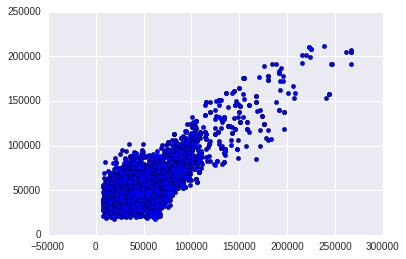

In [687]:
ax = plt.scatter(y_test, model.predict(X_test))
ax.set_xlim([0,300000])
ax.set_ylim([0,300000])

In [679]:
model.intercept_

-261138.53140623402

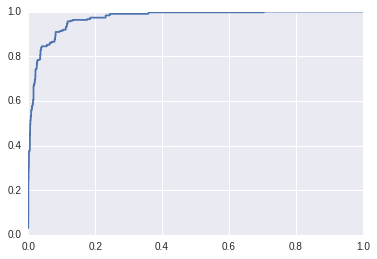

In [658]:
fpr, tpr, thre = roc_curve(y_test, [i[1] for i in model.predict_proba(X_test)])
plt.plot(fpr, tpr)

In [659]:
roc_auc_score(y_test, [i[1] for i in model.predict_proba(X_test)])

0.97051198331400279

In [660]:
print(classification_report(y_test,model.predict(X_test)))

             precision    recall  f1-score   support

          0       0.99      0.89      0.94      2773
          1       0.48      0.92      0.63       296

avg / total       0.94      0.90      0.91      3069



### Conclusion
The above result (ROC_AUC score of 0.89) indicates a decent level of model performance. It is a measure of the confidence that the majority of times, the model would be able to distinguish between a potential peak vs a non-peak.